CLEANING DATA

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import missingno as msno
from plotnine import *
import seaborn as sns
import warnings
from tabulate import tabulate
warnings.filterwarnings('ignore')

In [2]:
# Load semua dataset (Topik menyesuaikan)
course = pd.read_csv('courses.csv')
assesment = pd.read_csv('assessments.csv')
vle = pd.read_csv('vle.csv')
info_stu = pd.read_csv('studentInfo.csv')
reg_stu = pd.read_csv('studentRegistration.csv')
as_stu = pd.read_csv('studentAssessment.csv')
vle_stu = pd.read_csv('studentVle.csv')

In [3]:
# Bisa dilihat terdapat kolom code module dan code presentation hampir di setiap dataset
# Maka coba kita gabungkan code module dan code presentation untuk membuat fitur baru untuk mengidentifikasi masing masing modul hingga nilainya unik

course["module_presentation"] = list(map(lambda x,y: str(x) + "_" + str(y), course.code_module, course.code_presentation))
assesment["module_presentation"] = list(map(lambda x,y: str(x) + "_" + str(y), assesment.code_module, assesment.code_presentation))
vle["module_presentation"] = list(map(lambda x,y: str(x) + "_" + str(y), vle.code_module, vle.code_presentation))
info_stu["module_presentation"] = list(map(lambda x,y: str(x) + "_" + str(y), info_stu.code_module, info_stu.code_presentation))
reg_stu["module_presentation"] = list(map(lambda x,y: str(x) + "_" + str(y), reg_stu.code_module, reg_stu.code_presentation))
vle_stu["module_presentation"] = list(map(lambda x,y: str(x) + "_" + str(y), vle_stu.code_module, vle_stu.code_presentation))


print(" Di fitur student info terdapat; \n # {} baris\n # dan {} ID student yang unik \n \
Dapat dilihat disini ternyata nilai id student yang unik lebih sedikit sehingga seharusnya ada student yang mengikuti\
beberapa modul berbeda" .format(len(info_stu),len(info_stu.id_student.unique())))
print("\n Kesimpulannya adalah student id belum tentu menjadi nilai unik yang bisa berfungsi sebagai identifier dalam tabel\n")

 Di fitur student info terdapat; 
 # 32593 baris
 # dan 28785 ID student yang unik 
 Dapat dilihat disini ternyata nilai id student yang unik lebih sedikit sehingga seharusnya ada student yang mengikutibeberapa modul berbeda

 Kesimpulannya adalah student id belum tentu menjadi nilai unik yang bisa berfungsi sebagai identifier dalam tabel



<AxesSubplot: >

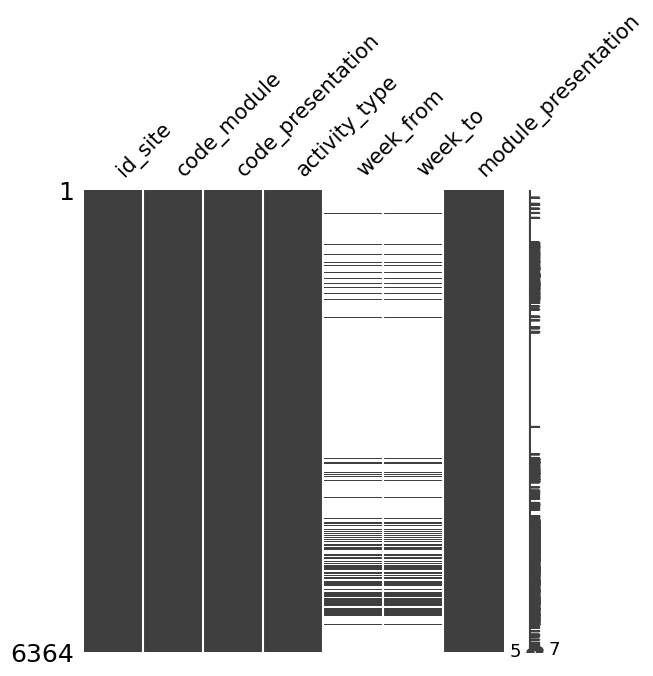

In [4]:
# Kita identifikasi missing value dari dataset LMS
msno.matrix(vle, figsize=(6,6), fontsize=15)

In [5]:
#Terlihat kolom week to dan week from kehilangan banyak data. Agar lebih jelas kita coba gunakan angka
vle.isnull().sum()

id_site                   0
code_module               0
code_presentation         0
activity_type             0
week_from              5243
week_to                5243
module_presentation       0
dtype: int64

In [6]:
#Kita handling missing values dengan drop nilai kosong
vle.drop(columns=['week_from','week_to'],inplace=True)

<AxesSubplot: >

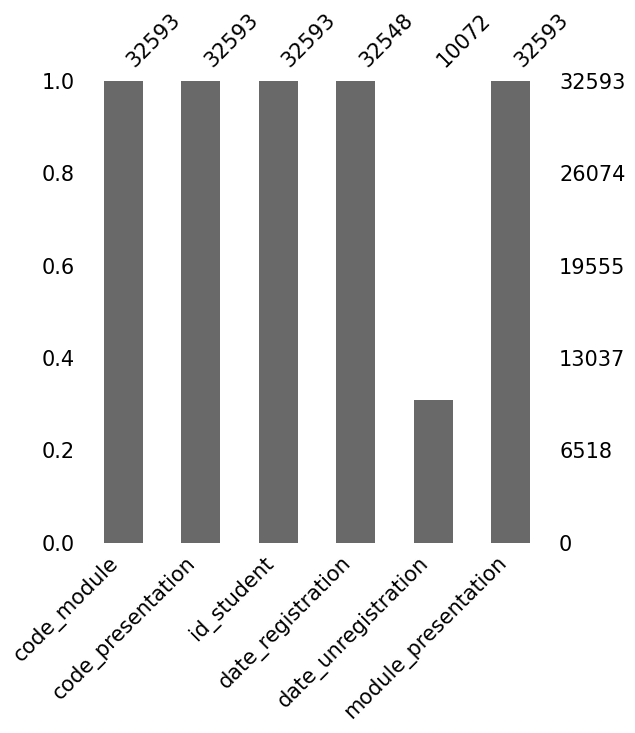

In [7]:
#Kali ini kita cek juga di dataset registrasi
msno.bar(reg_stu, figsize=(6,6), fontsize=15)

Dari tabel di atas ternyata banyak siswa yang tidak membatalkan "enroll" mereka dalam modul, bisa jadi karena memang demikian tapi bisa jadi juga karena tidak tercatat dalam dataset. Karenak kemungkinan terakhir tersebut maka kita harus analisis lebih lanjut. Caranya:

1. Mencari student yang tidak terdaftar dalam tabel registrasi
2. Setelah siswa yang tidak terdaftar telah diidentifikasi, langkah berikutnya adalah memeriksa data StudentInfo untuk melihat apakah (final result) yang dicatat untuk siswa-siswa ini sesuai dengan status mereka yang tidak terdaftar.Jika iya maka (final result) kita tandai sebagai mengundurkan diri (withdrawn) ketimbang gagal (fail)

In [8]:
# Kita pilih student yang tidak terdaftar di data student reg
temp = reg_stu.loc[reg_stu.date_unregistration.notna(),\
                               ['id_student','module_presentation','date_unregistration']]

# Lalu kita merge tabel student info untuk melihat baris yang cocok
temp =pd.merge(info_stu, temp, on=['id_student','module_presentation'])

# Lakukan pencarian semantic error, dimana kesalahannya bahwa student yang tidak terdaftar tidak ditandai mengundurkan diri
wrong_final_results=temp.loc[temp.final_result!='Withdrawn']
incorrect_final_results=wrong_final_results.index
wrong_final_results

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation,date_unregistration
719,BBB,2013J,362907,F,South West Region,Lower Than A Level,20-30%,35-55,2,60,N,Fail,BBB_2013J,0.0
724,BBB,2013J,365288,F,South Region,A Level or Equivalent,70-80%,0-35,0,60,N,Fail,BBB_2013J,0.0
869,BBB,2013J,554243,F,South West Region,Lower Than A Level,60-70%,0-35,0,60,N,Fail,BBB_2013J,166.0
4961,DDD,2013J,315082,M,West Midlands Region,A Level or Equivalent,50-60%,0-35,0,60,N,Fail,DDD_2013J,0.0
5010,DDD,2013J,403052,F,Yorkshire Region,HE Qualification,20-30%,0-35,0,150,N,Fail,DDD_2013J,0.0
5293,DDD,2013J,582954,M,London Region,Lower Than A Level,10-20,0-35,0,120,N,Fail,DDD_2013J,-7.0
7853,FFF,2013J,234004,M,Yorkshire Region,A Level or Equivalent,50-60%,0-35,0,60,N,Fail,FFF_2013J,0.0
8001,FFF,2013J,523777,M,North Region,A Level or Equivalent,0-10%,35-55,1,60,N,Fail,FFF_2013J,0.0
8340,FFF,2013J,601640,M,London Region,HE Qualification,20-30%,0-35,0,90,N,Fail,FFF_2013J,-4.0


Bisa dilihat padahal 8 student telah mengundurkan diri sebelum modul dimulai atau pada saat modul dimulai sedangkan 1 saat modul sudah dimulai (total 9 students) tetapi final result mereka fail ketimbang withdrawn

In [9]:
# Kita Cek sebelum kita rubah untuk memastikan saja
info_stu['final_result'].value_counts()

final_result
Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: count, dtype: int64

In [10]:
# Maka kita ubah error di atas dan tandai final result student dengan withdrawn
for i in wrong_final_results[['id_student','code_module','code_presentation']].values:
    info_stu.loc[(info_stu.id_student==i[0])&(info_stu.code_module==i[1])&\
                 (info_stu.code_presentation==i[2]),'final_result'] = 'Withdrawn'

In [11]:
# Cek apakah sudah berubah
info_stu['final_result'].value_counts()

final_result
Pass           12361
Withdrawn      10165
Fail            7043
Distinction     3024
Name: count, dtype: int64

Selanjutnya kita cek konsistensi data pada tabel assesment apakah sudah sesuai semuanya seperti yang ada pada website?

In [12]:
# Disini kita cek untuk bobot penilaian apakah sudah konsisten 200% semuanya
# Total yang benar adalah 200% berdasarkan penjelasan pada website oulad (100% assesment dan 100% exams)
assesment.groupby(['code_module','code_presentation']).agg(total_weight = ('weight',sum))

total_weight
code_module code_presentation              
AAA         2013J                     200.0
            2014J                     200.0
BBB         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
CCC         2014B                     300.0
            2014J                     300.0
DDD         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
EEE         2013J                     200.0
            2014B                     200.0
            2014J                     200.0
FFF         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
GGG         2013J                     100.0
            2014B                     100.0
            2014J                     100.0

Bobot modul CCC dan GGG ternyata mempunyai kesalahan atau inkonsistensi? Karena tidak sesuai bobot yang ditetapkan

In [13]:
# Maka coba kita lihat bagaimana penjumlahan nilai di modul yang salah tersebut
assesment[assesment.code_module.isin(["CCC","GGG"])]\
.groupby(['code_module','code_presentation',"assessment_type"]).agg(type_weights = ('weight',sum))

type_weights
code_module code_presentation assessment_type              
CCC         2014B             CMA                      25.0
                              Exam                    200.0
                              TMA                      75.0
            2014J             CMA                      25.0
                              Exam                    200.0
                              TMA                      75.0
GGG         2013J             CMA                       0.0
                              Exam                    100.0
                              TMA                       0.0
            2014B             CMA                       0.0
                              Exam                    100.0
                              TMA                       0.0
            2014J             CMA                       0.0
                              Exam                    100.0
                              TMA                       0.0

Kesalahan pada modul CCC ternyata pada Exam bobotnya sudah 200% ketimbang 100% ini bisa jadi kesalahan input\
Kesalahan pada modul GGG adalah tugas tidak diberikan nilai dan hanya exam yang diberikan

In [14]:
# Maka nilai Exam modul CCC kita bagi 2 menjadi 100%
assesment.loc[(assesment.code_module=='CCC') &(assesment.assessment_type=='Exam'),'weight'] = \
assesment.loc[(assesment.code_module=='CCC') &(assesment.assessment_type=='Exam'),'weight']/2

# Nilai penugasan (TMA) modul GGG kita jadikan 100% pada 3 tahun yang ada
# Kenapa TMA? Karena TMA adalah nilai tugas yang diberikan dosen(Manusia) sedangkan CMA Computer->(Mungkin tidak melakukan kesalahan)
assesment.loc[(assesment.code_module=='GGG') & (assesment.assessment_type=='TMA'),'weight']=(100/3)

In [15]:
# Seperti byasa kita cek
assesment[assesment.code_module.isin(["CCC","GGG"])]\
.groupby(['code_module','code_presentation',"assessment_type"]).agg(type_weights = ('weight',sum))

type_weights
code_module code_presentation assessment_type              
CCC         2014B             CMA                      25.0
                              Exam                    100.0
                              TMA                      75.0
            2014J             CMA                      25.0
                              Exam                    100.0
                              TMA                      75.0
GGG         2013J             CMA                       0.0
                              Exam                    100.0
                              TMA                     100.0
            2014B             CMA                       0.0
                              Exam                    100.0
                              TMA                     100.0
            2014J             CMA                       0.0
                              Exam                    100.0
                              TMA                     100.0

Jika sudah memperbaiki tabel assessments maka sekarang kita coba hitung bobot nilai pada tabel student asses untuk menentukan apakah mereka lulus atau tidak? Kita coba untuk menghitung nilai mereka secara numerik dengan cara menambahkan satu fitur baru untuk menentukan kelulusan mereka ketimbang menggunakan nilai secara kategorikal yang sudah ada (final result)

Perbaikan data dengan menambah fitur fitur baru untuk hasil prediksi lebih baik

In [16]:
# Kita coba gabungkan 2 tabel yaitu score dan weight untuk menghitung nilai akhir mereka

# Kita merge tabel student assessment dan assessments
joined=pd.merge(as_stu,assesment,on='id_assessment',how='left')
# Kalkulasikan secara numerik nilai mereka dengan mengkalikan nilai dan bobot tugas
joined['score*weight']=(joined['score']*joined['weight'])

# Kita sesuaikan nilai penugasan mereka yang telah dikali bobot dalam kolom "score*weight"
# Untuk menyesuaikan maka kita harus membaginya dengan total bobot modul (200)
marks=joined.groupby(['id_student','code_module','code_presentation'],as_index=False)[['score*weight','weight']].sum()

marks['adjusted_mark'] = marks['score*weight']/marks['weight']
marks["mark"]  = marks['score*weight']/200
marks.rename(columns = {'score*weight': 'total_score*weight', 'weight': 'attempted_weight'}, inplace=True)
marks = marks.round(1)

Oke, pada penjelasan dataset di website oulad, Students bisa dinyatakan gagal (final result) jika nilai mereka di bawah 40 (secara numerik). Mari kita cek apakah sudah benar bahwa student yang dinyatakan gagal dalam final result nilainya sudah pasti <=40? Karena terdapat kemungkinan bahwa student dengan nilai lebih dari 40 dinyatakan gagal, kemungkinannya 2:

1. total bobot (total_weight) dari semua penugasan untuk beberapa siswa tidak mencapai 200 (total bobot yang diharapkan), dan bahwa dalam kasus ini, siswa yang tidak mencoba suatu penugasan akan mendapatkan nilai 0, maka beberapa siswa mungkin mendapatkan nilai akhir yang lebih rendah dari 40 dan seharusnya memiliki status akhir "Fail."
2. bahwa beberapa siswa mungkin telah mencoba lebih banyak penugasan daripada yang terdokumentasikan dalam dataset. Dalam hal ini, nilai atau penilaian dari penugasan tambahan tersebut tidak dimasukkan dalam dataset. Sebagai hasilnya, penugasan yang tidak terdokumentasikan dianggap tidak ada dalam perhitungan nilai akhir.

In [17]:
# Merging Tabel
joined = pd.merge(marks, info_stu, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Menangani Hasil Akhir "Withdrawn"
joined.loc[joined.final_result == 'Withdrawn', 'mark'] = np.nan
joined.loc[joined.final_result == 'Withdrawn', 'adjusted_mark'] = np.nan

# Menampilkan Statistik Bobot Penugasan Berdasarkan Hasil Akhir
statistics_by_result = joined.groupby('final_result')['attempted_weight'].describe()

# Menampilkan Statistik Bobot Penugasan
print(statistics_by_result)

# Konversi hasil statistik menjadi tabel teks
table = tabulate(statistics_by_result)

# Menampilkan tabel teks
print(table)

                count        mean        std   min    25%    50%    75%    max
final_result                                                                  
Distinction    3024.0  117.182308  35.305252  66.7  100.0  100.0  119.0  200.0
Fail           5766.0   63.827315  51.719295   0.0   24.0   50.0  100.0  200.0
Pass          12358.0  117.800922  39.394520   0.0  100.0  100.0  120.0  200.0
Withdrawn      4695.0   27.915293  24.190850   0.0   10.0   22.5   43.0  140.0
-----------  -----  --------  -------  ----  ---  -----  ---  ---
Distinction   3024  117.182   35.3053  66.7  100  100    119  200
Fail          5766   63.8273  51.7193   0     24   50    100  200
Pass         12358  117.801   39.3945   0    100  100    120  200
Withdrawn     4695   27.9153  24.1909   0     10   22.5   43  140
-----------  -----  --------  -------  ----  ---  -----  ---  ---


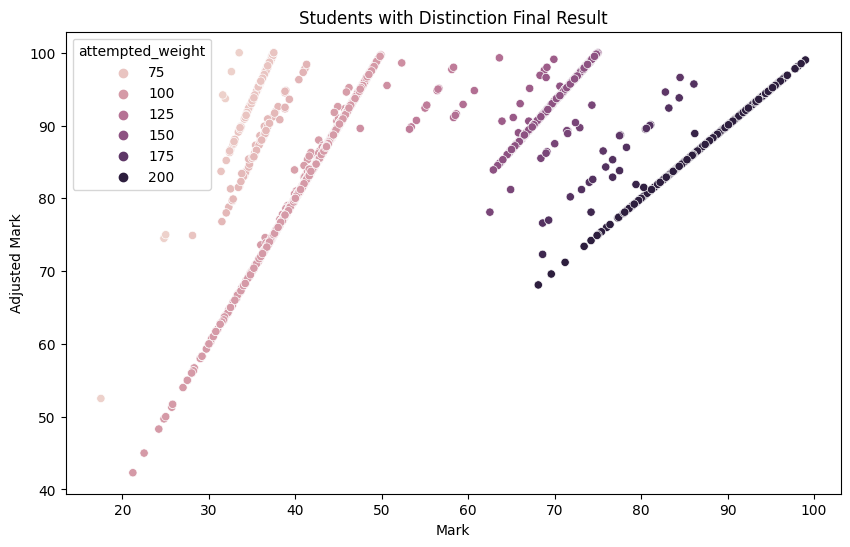

In [18]:
# Filter data untuk siswa dengan hasil akhir "Distinction"
distinction_data = joined[joined.final_result == "Distinction"]

# Membuat scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=distinction_data, x="mark", y="adjusted_mark", hue="attempted_weight")
plt.title("Students with Distinction Final Result")
plt.xlabel("Mark")
plt.ylabel("Adjusted Mark")
plt.show()

In [19]:
# Penggabungan Tabel
joined = pd.merge(marks, info_stu, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Menangani Hasil Akhir "Withdrawn"
joined.loc[joined.final_result == 'Withdrawn', 'mark'] = np.nan
joined.loc[joined.final_result == 'Withdrawn', 'adjusted_mark'] = np.nan

# Analisis Statistik
statistics_by_result = joined.groupby('final_result')[['mark', 'adjusted_mark', 'attempted_weight']].describe()

# Menampilkan Statistik
print(statistics_by_result)


                 mark                                                        \
                count       mean        std   min   25%   50%     75%   max   
final_result                                                                  
Distinction    3024.0  51.242692  17.112732  17.5  41.3  44.4  56.525  99.0   
Fail           5766.0  17.952688  13.373976   0.0   6.9  15.8  27.400  67.2   
Pass          12358.0  42.249377  14.559568   0.0  33.0  38.6  45.600  95.3   
Withdrawn         0.0        NaN        NaN   NaN   NaN   NaN     NaN   NaN   

             adjusted_mark             ...              attempted_weight  \
                     count       mean  ...   75%    max            count   
final_result                           ...                                 
Distinction         3024.0  86.999735  ...  92.5  100.0           3024.0   
Fail                5677.0  59.781962  ...  72.0  100.0           5766.0   
Pass               12357.0  72.288978  ...  80.7   98.7          1

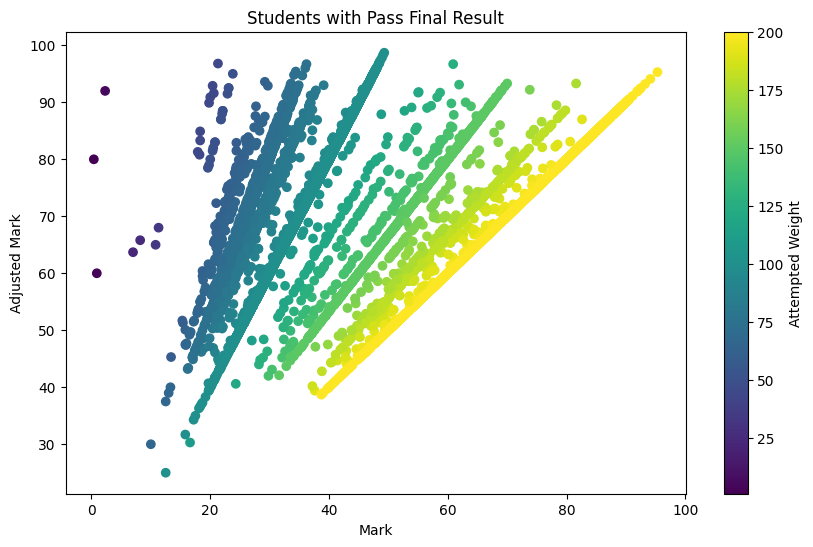

               mark  adjusted_mark  attempted_weight
count  12358.000000   12357.000000      12358.000000
mean      42.249377      72.288978        117.800922
std       14.559568      11.193744         39.394520
min        0.000000      25.000000          0.000000
25%       33.000000      65.000000        100.000000
50%       38.600000      73.400000        100.000000
75%       45.600000      80.700000        120.000000
max       95.300000      98.700000        200.000000


In [20]:
# Penggabungan Tabel
joined = pd.merge(marks, info_stu, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Menangani Hasil Akhir "Withdrawn"
joined.loc[joined.final_result == 'Withdrawn', 'mark'] = np.nan
joined.loc[joined.final_result == 'Withdrawn', 'adjusted_mark'] = np.nan

# Filter data untuk siswa dengan hasil akhir "Pass"
pass_data = joined[joined.final_result == "Pass"]

# Membuat Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(pass_data['mark'], pass_data['adjusted_mark'], c=pass_data['attempted_weight'], cmap='viridis')
plt.colorbar(label='Attempted Weight')
plt.title("Students with Pass Final Result")
plt.xlabel("Mark")
plt.ylabel("Adjusted Mark")
plt.show()

# Analisis Statistik untuk Siswa dengan Hasil Akhir "Pass"
statistics_for_pass = pass_data[['mark', 'adjusted_mark', 'attempted_weight']].describe()

# Menampilkan Statistik
print(statistics_for_pass)

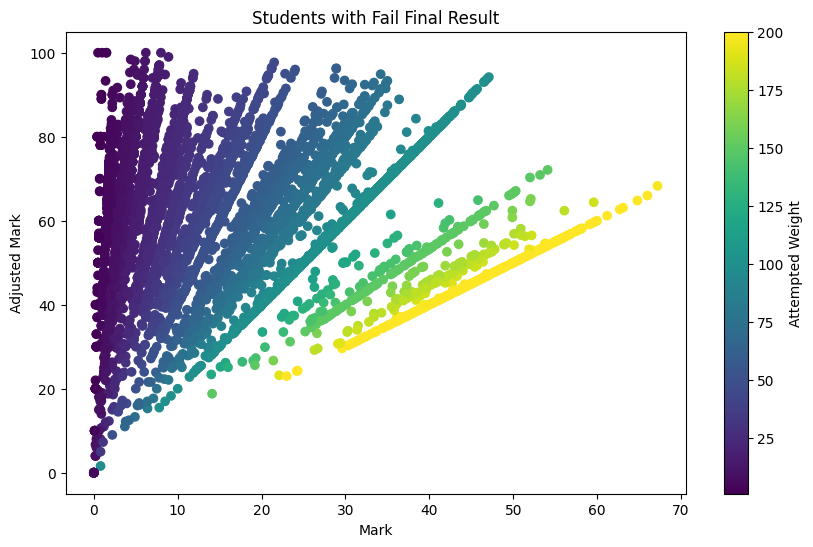

              mark  adjusted_mark  attempted_weight
count  5766.000000    5677.000000       5766.000000
mean     17.952688      59.781962         63.827315
std      13.373976      16.814398         51.719295
min       0.000000       0.000000          0.000000
25%       6.900000      48.300000         24.000000
50%      15.800000      60.200000         50.000000
75%      27.400000      72.000000        100.000000
max      67.200000     100.000000        200.000000


In [21]:
# Penggabungan Tabel
joined = pd.merge(marks, info_stu, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Menangani Hasil Akhir "Withdrawn"
joined.loc[joined.final_result == 'Withdrawn', 'mark'] = np.nan
joined.loc[joined.final_result == 'Withdrawn', 'adjusted_mark'] = np.nan

# Filter data untuk siswa dengan hasil akhir "Fail"
fail_data = joined[joined.final_result == "Fail"]

# Membuat Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(fail_data['mark'], fail_data['adjusted_mark'], c=fail_data['attempted_weight'], cmap='viridis')
plt.colorbar(label='Attempted Weight')
plt.title("Students with Fail Final Result")
plt.xlabel("Mark")
plt.ylabel("Adjusted Mark")
plt.show()

# Analisis Statistik untuk Siswa dengan Hasil Akhir "Fail"
statistics_for_fail = fail_data[['mark', 'adjusted_mark', 'attempted_weight']].describe()

# Menampilkan Statistik
print(statistics_for_fail)

Dari analisa di atas memang benar hampir semua siswa dengan nilai 70 keatas mendapatkan label "distinction"n\
Dan hampir semua siswa dengan nilai 40 keatas dinyatakan "Pass"n\
Tapi ternyata ada data yang salah karena ada siswa gagal dengan nilai di atas 40n\

## Kode Penjelasan dan Komentar

Dalam kode di bawah, kita membuat beberapa indeks berdasarkan kriteria tertentu dalam DataFrame yang disebut "joined." Setiap indeks mewakili kategori atau subset data yang berbeda.

### Kategori "final_result":

- `distinction`: Indeks untuk kategori "Distinction" dalam kolom "final_result."
- `passing`: Indeks untuk kategori "Pass" dalam kolom "final_result."
- `fail`: Indeks untuk kategori "Fail" dalam kolom "final_result."
- `withdraw`: Indeks untuk kategori "Withdraw" dalam kolom "final_result."

### Kategori "attempted_weight":

- `attempt_weight200`: Indeks untuk kategori "attempted_weight" yang sama dengan 200.
- `attempt_weight150_200`: Indeks untuk kategori "attempted_weight" antara 150 dan 200 (tidak termasuk 200).
- `attempt_weight0_150`: Indeks untuk kategori "attempted_weight" kurang dari 150.

### Kategori "attempted_weight" dengan penyesuaian:

- `adj_mark80_100`: Indeks untuk kategori "attempted_weight" yang lebih besar atau sama dengan 80.
- `adj_mark70_80`: Indeks untuk kategori "attempted_weight" antara 70 dan 80.
- `adj_mark0_70`: Indeks untuk kategori "attempted_weight" kurang dari 70.

### Kategori "attempted_weight" dengan batasan tertentu:

- `mark40_100`: Indeks untuk kategori "attempted_weight" yang lebih besar atau sama dengan 40.
- `mark0_40`: Indeks untuk kategori "attempted_weight" kurang dari 40.

Dengan membuat indeks-indeks ini, kita dapat dengan mudah mengakses dan memproses subset data yang sesuai dengan kriteria tertentu, yang berguna untuk analisis lebih lanjut atau pemrosesan data.


In [22]:
distinction = joined[joined.final_result=="Distinction"].index
passing = joined[joined.final_result=="Pass"].index
fail = joined[joined.final_result=="Fail"].index
withdraw = joined[joined.final_result=="Withdraw"].index


attempt_weight200 = joined[joined.attempted_weight==200].index
attempt_weight150_200 = joined[(joined.attempted_weight>=150) & (joined.attempted_weight!=200)].index
attempt_weight0_150 = joined.index.difference(attempt_weight200).difference(attempt_weight150_200)

adj_mark80_100 = joined[joined.attempted_weight>=80].index
adj_mark70_80 = joined[(joined.attempted_weight>=70) & (joined.attempted_weight<80)].index
adj_mark0_70 = joined[joined.attempted_weight<70].index

mark40_100 = joined[joined.attempted_weight>=40].index
mark0_40 = joined[joined.attempted_weight<40].index

In [23]:
# Perlu diingat attempt weight adalah pengerjaan setiap bobot yang diberi (Tugas/exam)
# Students with attempted_weight 200

condition_distinction = (joined.attempted_weight == 200) & (joined.adjusted_mark >= 80) & (joined.adjusted_mark <= 100)
condition_passing = (joined.attempted_weight == 200) & (joined.adjusted_mark >= 70) & (joined.adjusted_mark < 80)
condition_fail = (joined.attempted_weight == 200) & (joined.adjusted_mark >= 0) & (joined.adjusted_mark < 70)

joined.loc[condition_distinction, "final_result"] = "Distinction"
joined.loc[condition_passing, "final_result"] = "Pass"
joined.loc[condition_fail, "final_result"] = "Fail"

# Students with attempted_weight between 150 and 200
condition_distinction_150_200 = (joined.attempted_weight >= 150) & (joined.attempted_weight < 200) & (joined.adjusted_mark >=80) & (joined.adjusted_mark <=100)
condition_pass_150_200 = (joined.attempted_weight >= 150) & (joined.attempted_weight < 200) & (joined.adjusted_mark >=40) & (joined.adjusted_mark <100)

joined.loc[condition_distinction_150_200, "final_result"] = "Distinction"
joined.loc[condition_pass_150_200, "final_result"] = "Pass"
joined.loc[condition_pass_150_200, "adjusted_mark"] = joined.loc[condition_pass_150_200, "mark"]



df = joined

<AxesSubplot: xlabel='adjusted_mark', ylabel='Density'>

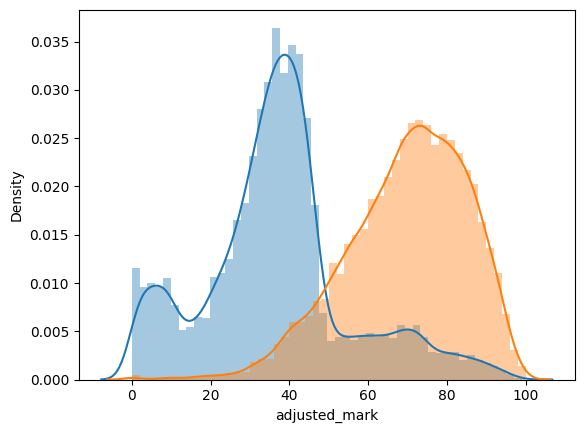

In [24]:
sns.distplot(df.loc[df.mark.notnull(),"mark"])
sns.distplot(df.loc[df.adjusted_mark.notnull(),"adjusted_mark"])

Plot tersebut menggambarkan beberapa informasi tentang dua variabel dalam dataset, yaitu "adjusted_mark" dan "mark," serta dampak dari perubahan tersebut pada pengukuran kesuksesan siswa:

"adjusted_mark" adalah Pengukuran yang Lebih Seimbang: Pesan tersebut mengindikasikan bahwa "adjusted_mark" adalah pengukuran yang lebih seimbang. Artinya, distribusi nilai "adjusted_mark" cenderung lebih merata atau lebih mendekati distribusi normal. Ini mungkin disebabkan oleh distribusi linier dari nilai total_weight yang kurang dari 150. Distribusi yang lebih merata ini dapat memberikan gambaran yang lebih objektif tentang kinerja siswa.

"mark" adalah Pengukuran yang Cenderung Right-Skewed: Di sisi lain, "mark" adalah pengukuran yang cenderung right-skewed atau miring ke kanan. Ini berarti sebagian besar siswa mungkin memiliki nilai yang lebih tinggi, tetapi ada beberapa siswa yang memiliki nilai yang jauh lebih rendah, terutama jika beberapa tugas dihitung sebagai nol. Hal ini dapat menyebabkan distribusi yang tidak merata.

"adjusted_mark" adalah Pengukuran yang Lebih Optimis: Pesan tersebut juga menyatakan bahwa "adjusted_mark" adalah pengukuran yang lebih optimis dalam hal kesuksesan siswa. Ini mungkin terjadi karena "adjusted_mark" mencoba untuk mengoreksi nilai yang rendah atau nol untuk tugas yang mungkin seharusnya memiliki nilai yang lebih tinggi. Dengan demikian, "adjusted_mark" dapat memberikan gambaran yang lebih positif tentang kemajuan siswa.

In [25]:
df

,id_student,code_module,code_presentation,total_score*weight,attempted_weight,adjusted_mark,mark,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation
0,6516,AAA,2014J,6350.0,100.0,63.5,31.8,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,AAA_2014J
1,8462,DDD,2013J,3490.0,40.0,NaN,NaN,M,London Region,HE Qualification,30-40%,55<=,0,90,N,Withdrawn,DDD_2013J
2,8462,DDD,2014J,4300.0,50.0,NaN,NaN,M,London Region,HE Qualification,30-40%,55<=,1,60,N,Withdrawn,DDD_2014J
3,11391,AAA,2013J,8240.0,100.0,82.4,41.2,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,AAA_2013J
4,23629,BBB,2013B,1669.0,25.0,66.8,8.3,F,East Anglian Region,Lower Than A Level,20-30%,0-35,2,60,N,Fail,BBB_2013B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25838,2698257,AAA,2013J,6940.0,100.0,69.4,34.7,M,East Midlands Region,Lower Than A Level,60-70%,0-35,0,120,N,Pass,AAA_2013J
25839,2698535,CCC,2014B,937.0,39.0,NaN,NaN,M,Wales,Lower Than A Level,50-60%,0-35,0,60,N,Withdrawn,CCC_2014B
25840,2698535,EEE,2013J,5344.0,100.0,53.4,26.7,M,Wales,Lower Than A Level,50-60%,0-35,0,60,N,Pass,EEE_2013J
25841,2698577,BBB,2014J,5580.0,100.0,55.8,27.9,F,Wales,Lower Than A Level,50-60%,35-55,0,60,N,Fail,BBB_2014J


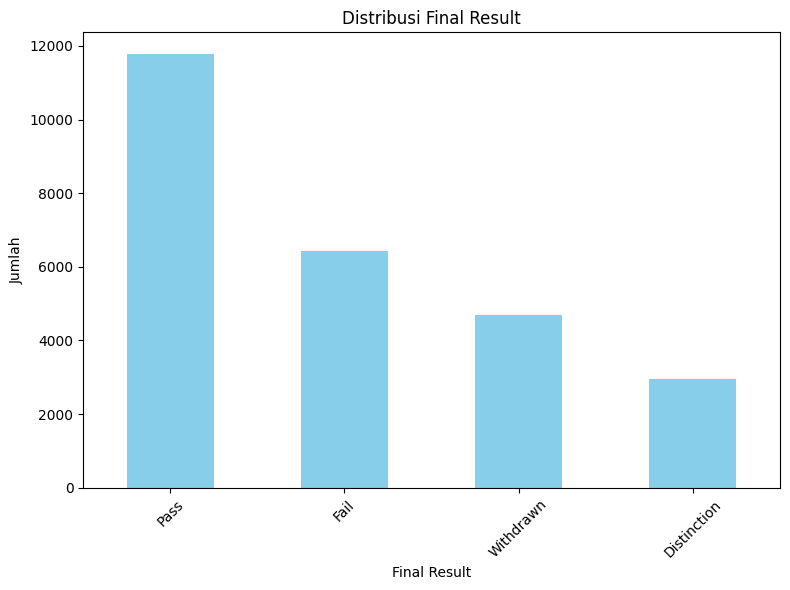

In [26]:
# Hitung frekuensi masing-masing kategori dalam kolom 'final_result'
result_counts = df['final_result'].value_counts()

# Buat plot bar menggunakan Matplotlib
plt.figure(figsize=(8, 6))  # Atur ukuran plot
result_counts.plot(kind='bar', color='skyblue')  # Jenis plot 'bar' dengan warna skyblue
plt.title('Distribusi Final Result')  # Judul plot
plt.xlabel('Final Result')  # Label sumbu x
plt.ylabel('Jumlah')  # Label sumbu y
plt.xticks(rotation=45)  # Rotasi label sumbu x jika perlu
plt.tight_layout()  # Penataan layout agar tidak tumpang tindih
plt.show()  # Tampilkan plot

**Konsistensi Antara "final_result" dan "adjusted_mark"**

Pengamatan pada plot di atas menunjukkan bahwa variabel "final_result" memiliki distribusi yang cukup seragam dibandingkan dengan variabel "mark". Ini berarti bahwa kategori-kategori dalam "final_result" cenderung terdistribusi secara merata tanpa dominasi yang signifikan.

Selain itu, dapat dinyatakan bahwa "final_result" dan "adjusted_mark" menunjukkan konsistensi yang kuat. Artinya, hasil akhir ("final_result") dan nilai yang telah disesuaikan ("adjusted_mark") tampaknya memiliki hubungan yang sejalan. Ini mungkin mengindikasikan bahwa "adjusted_mark" didesain untuk memberikan pengukuran yang lebih objektif atau korektif terhadap "mark," sehingga menghasilkan hasil akhir yang lebih seimbang dan konsisten.

Pemahaman ini dapat memberikan wawasan tambahan tentang bagaimana variabel "final_result" dan "adjusted_mark" berkaitan dalam konteks analisis data.


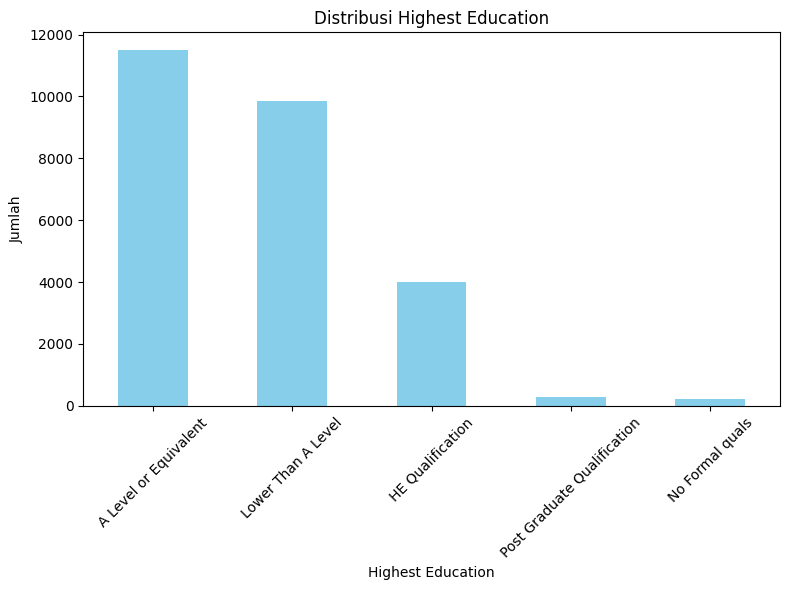

In [27]:
# Hitung frekuensi masing-masing kategori dalam kolom 'edu'
education_counts = df['highest_education'].value_counts()

# Buat plot bar menggunakan Matplotlib
plt.figure(figsize=(8, 6))  # Atur ukuran plot
education_counts.plot(kind='bar', color='skyblue')  # Jenis plot 'bar' dengan warna skyblue
plt.title('Distribusi Highest Education')  # Judul plot
plt.xlabel('Highest Education')  # Label sumbu x
plt.ylabel('Jumlah')  # Label sumbu y
plt.xticks(rotation=45)  # Rotasi label sumbu x jika perlu
plt.tight_layout()  # Penataan layout agar tidak tumpang tindih
plt.show()  # Tampilkan plot

**Penggabungan Kategori Pendidikan**

Pada plot diatas kita dapat melihat variabel pendidikan di mana sangat sedikit siswa yang memiliki gelar universitas atau tingkat pendidikan yang lebih tinggi. Jumlah data yang sangat sedikit dalam kelompok ini dapat menghasilkan ketidakpastian atau hasil yang tidak dapat diandalkan dalam analisis.

Untuk mengatasi masalah ini, mungkin ide yang baik untuk menggabungkan beberapa kelompok kategori pendidikan menjadi dua kelompok yang lebih umum: "HE or higher" (Pendidikan Tinggi atau Lebih Tinggi) dan "Level or lower" (Pendidikan Tingkat atau Lebih Rendah). Dengan penggabungan ini, kita dapat memiliki kelompok yang lebih besar dan lebih relevan untuk analisis lebih lanjut, sambil mempertahankan informasi esensial tentang tingkat pendidikan.

Langkah ini dapat membantu meningkatkan validitas statistik dan memungkinkan kita untuk membuat kesimpulan yang lebih meyakinkan berdasarkan data yang tersedia.


In [28]:
df

,id_student,code_module,code_presentation,total_score*weight,attempted_weight,adjusted_mark,mark,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation
0,6516,AAA,2014J,6350.0,100.0,63.5,31.8,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,AAA_2014J
1,8462,DDD,2013J,3490.0,40.0,NaN,NaN,M,London Region,HE Qualification,30-40%,55<=,0,90,N,Withdrawn,DDD_2013J
2,8462,DDD,2014J,4300.0,50.0,NaN,NaN,M,London Region,HE Qualification,30-40%,55<=,1,60,N,Withdrawn,DDD_2014J
3,11391,AAA,2013J,8240.0,100.0,82.4,41.2,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,AAA_2013J
4,23629,BBB,2013B,1669.0,25.0,66.8,8.3,F,East Anglian Region,Lower Than A Level,20-30%,0-35,2,60,N,Fail,BBB_2013B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25838,2698257,AAA,2013J,6940.0,100.0,69.4,34.7,M,East Midlands Region,Lower Than A Level,60-70%,0-35,0,120,N,Pass,AAA_2013J
25839,2698535,CCC,2014B,937.0,39.0,NaN,NaN,M,Wales,Lower Than A Level,50-60%,0-35,0,60,N,Withdrawn,CCC_2014B
25840,2698535,EEE,2013J,5344.0,100.0,53.4,26.7,M,Wales,Lower Than A Level,50-60%,0-35,0,60,N,Pass,EEE_2013J
25841,2698577,BBB,2014J,5580.0,100.0,55.8,27.9,F,Wales,Lower Than A Level,50-60%,35-55,0,60,N,Fail,BBB_2014J


In [29]:
# Kita gabungkan fitur highest education menjadi 2 grup masukkan dalam fitur baru bernama edu
df["edu"] = list(map(lambda x: "HE or higher" if (x in ["HE Qualification", "Post Graduate Qualification"]) \
                else "Level or lower",df.highest_education))

df = df.drop(["total_score*weight","highest_education","module_presentation"], axis=1)

In [30]:
# menghitung jumlah interaksi setiap siswa pada lms
clicks = pd.merge(vle_stu, vle, on=["id_site"])
clicks = clicks.loc[:,["code_module_x","code_presentation_x","id_student","id_site","date","sum_click","activity_type"]]
clicks.rename(columns = {'code_module_x': 'code_module', 'code_presentation_x': 'code_presentation'}, inplace=True)

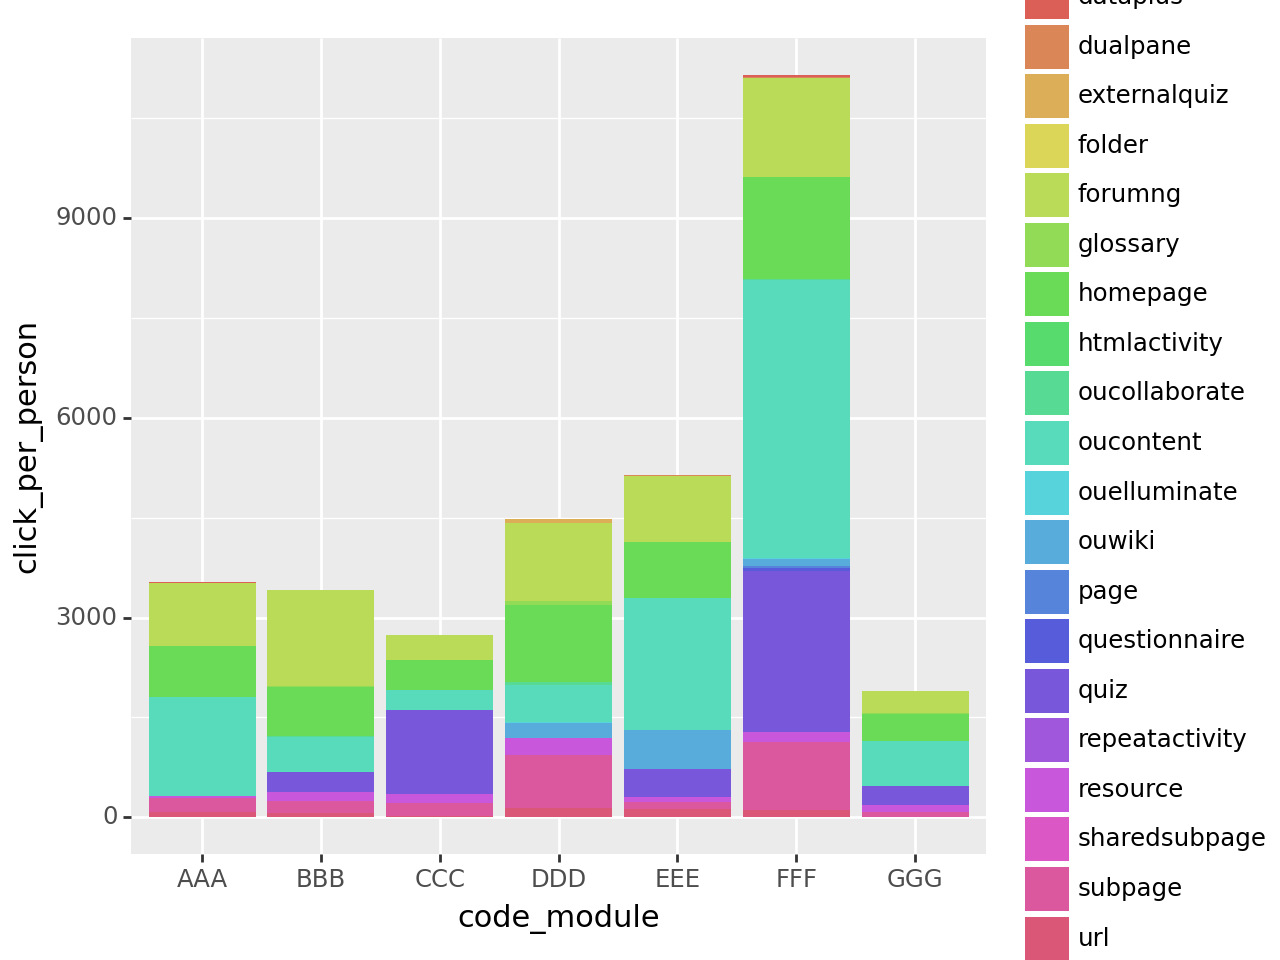

<Figure Size: (640 x 480)>

In [31]:
# Jumlah siswa untuk setiap modul dan presentation
number_of_students = df.groupby(["code_module","code_presentation"])\
    .agg(stu_count =("id_student", lambda x: x.nunique())).reset_index()

# Angka total interaksi
grouped_clicks = clicks.groupby(["code_module","code_presentation","activity_type"])\
.agg(total_click = ("sum_click",sum)).reset_index()

# Interaksi per student
grouped_clicks=pd.merge(grouped_clicks, number_of_students, on=["code_module","code_presentation"], how="left")
grouped_clicks["click_per_person"] = (grouped_clicks["total_click"]/grouped_clicks["stu_count"]).round(1)

ggplot(grouped_clicks, aes(fill="activity_type", y="click_per_person", x="code_module")) + \
    geom_bar(position="stack", stat="identity")

Dari plot yang dihasilkan dari kode di atas, kita dapat membaca beberapa informasi penting:

Kelompok Aktivitas: Grafik menggunakan warna untuk membedakan kelompok aktivitas atau jenis interaksi yang berbeda (activity_type). Ini membantu kita melihat kontribusi masing-masing jenis aktivitas terhadap total interaksi.

Modul Pembelajaran: Grafik ini membagi data berdasarkan modul pembelajaran (code_module). Setiap modul direpresentasikan oleh batang vertikal di sumbu x.

Interaksi Rata-rata per Siswa: Tinggi batang vertikal menunjukkan rata-rata jumlah interaksi (click_per_person) per siswa dalam modul pembelajaran tertentu. Semakin tinggi batangnya, semakin banyak interaksi per siswa.

Dengan mengamati grafik, kita dapat mengidentifikasi modul pembelajaran yang memiliki tingkat interaksi yang lebih tinggi atau lebih rendah per siswa. Selain itu, kita dapat melihat kontribusi jenis aktivitas tertentu dalam interaksi keseluruhan dalam setiap modul.

Penggunaan warna pada grafik memungkinkan kita untuk membedakan berbagai jenis aktivitas dengan mudah. Jika ada aktivitas tertentu yang dominan dalam suatu modul, hal ini akan terlihat dari warna batang yang dominan pada grafik tersebut.

Grafik ini membantu untuk memahami pola interaksi siswa dengan materi pembelajaran dalam berbagai modul dan jenis aktivitas. Ini bisa menjadi dasar untuk analisis lebih lanjut tentang efektivitas modul atau jenis aktivitas tertentu dalam menarik perhatian siswa atau mendorong partisipasi mereka dalam pembelajaran online.

In [75]:
result_counts =  df.groupby(["edu"]).final_result.value_counts().reset_index(name="hitung")

In [76]:
result_counts

,edu,final_result,hitung
0,HE or higher,Pass,2060
1,HE or higher,Fail,810
2,HE or higher,Distinction,700
3,HE or higher,Withdrawn,700
4,Level or lower,Pass,9718
5,Level or lower,Fail,5609
6,Level or lower,Withdrawn,3995
7,Level or lower,Distinction,2251


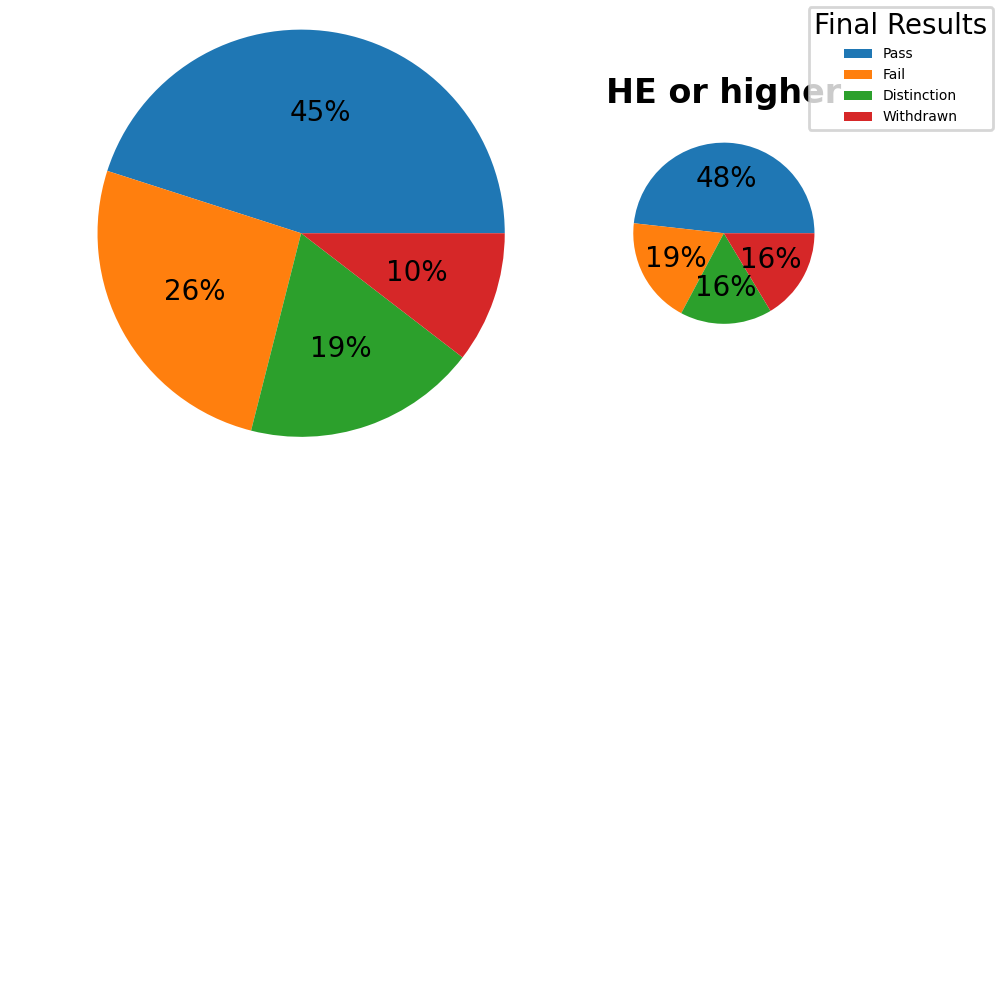

In [79]:
# Draw the pie charts
labels = list(result_counts.final_result.unique())
fracs1 = list(result_counts.iloc[4:,].hitung)
fracs2 = list(result_counts.iloc[:4,].hitung)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(321)
ax1.pie(fracs1, radius=np.sqrt(sum(fracs1)/sum(fracs2)), autopct='%.0f%%')
ax1.set_title("Level or lower", fontdict={'fontweight':"bold"}, pad=80)


ax2 = fig.add_subplot(322)
ax2.pie(fracs2,  autopct='%.0f%%')
ax2.set_title("HE or higher", fontdict={'fontweight':"bold"})


fig.legend(labels=labels, title="Final Results",prop={'size': 5})
plt.show()

Dari hasil plot analisis data, terlihat bahwa tingkat kesuksesan mahasiswa, terutama dalam kategori "Distinction", cenderung meningkat seiring dengan tingkat pendidikan yang lebih tinggi. Dalam hal ini:

Tingkat "Distinction" meningkat dari 22% menjadi 33% ketika tingkat pendidikan meningkat.\
Tingkat "Pass" memiliki perbedaan yang tidak terlalu signifikan antara kelompok pendidikan tinggi dan rendah.\
Tingkat "Withdraw" sedikit lebih rendah untuk kelompok pendidikan tinggi.\
Tingkat "Fail" juga sedikit lebih rendah untuk kelompok pendidikan tinggi.\

Dari hasil ini, dapat disimpulkan bahwa variabel "edu" (tingkat pendidikan) mungkin dapat digunakan sebagai prediktor dalam menilai keberhasilan mahasiswa, seperti yang dapat diantisipasi berdasarkan logika atau intuisi. Ini berarti bahwa ada korelasi antara tingkat pendidikan dan tingkat keberhasilan akademik dalam dataset yang Anda analisis. Tingkat pendidikan bisa menjadi salah satu faktor yang berpengaruh terhadap hasil akademik mahasiswa.

In [80]:
# Menghitung rata-rata dari kolom "adjusted_mark" untuk setiap kategori "imd_band" dalam dataset
df.groupby(["imd_band"]).agg(avg_adjusted_mark=("adjusted_mark",lambda x: x.mean()))

,avg_adjusted_mark
imd_band,
0-10%,65.363351
10-20,66.980766
20-30%,68.916713
30-40%,69.385301
40-50%,69.915176
50-60%,69.800332
60-70%,70.785015
70-80%,70.940262
80-90%,71.848791



Dengan melihat rata-rata nilai yang disesuaikan (adjusted mark) dari siswa-siswa dari berbagai nilai imd_band (yang merupakan indeks deprivasi dari daerah tempat tinggal siswa), kita dapat melihat bahwa siswa cenderung lebih berhasil di daerah-daerah yang lebih terdeprivasi. Hasil ini mungkin terdengar kontradiktif karena dalam sistem pendidikan tradisional (pendidikan tatap muka), merupakan fakta yang sudah umum diketahui bahwa siswa di daerah yang lebih maju cenderung lebih berhasil.

Hasil ini mengimplikasikan bahwa dalam pendidikan online, beberapa dinamika dapat berbeda, seperti efek tingkat perkembangan daerah tempat siswa berada. Ini berarti bahwa dalam pendidikan online, faktor-faktor lain seperti aksesibilitas teknologi, lingkungan belajar, atau motivasi siswa mungkin memiliki dampak yang lebih besar daripada faktor-faktor yang memengaruhi pendidikan tatap muka. Dengan kata lain, dalam konteks pendidikan online, keberhasilan siswa mungkin dipengaruhi oleh faktor-faktor yang berbeda atau memiliki dinamika yang berbeda daripada dalam pendidikan tatap muka.

<AxesSubplot: xlabel='age_band', ylabel='adjusted_mark'>

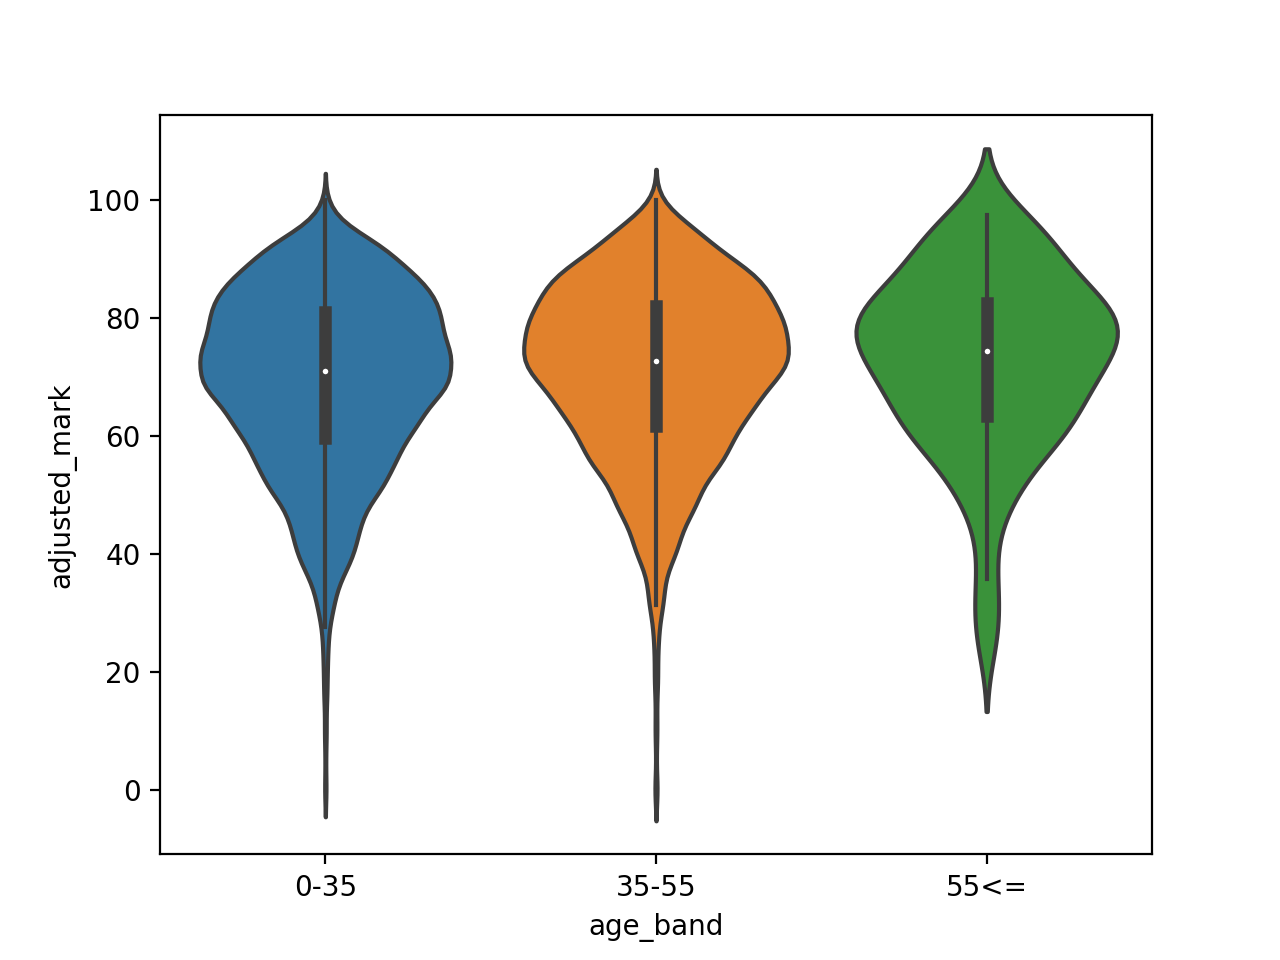

In [81]:
# Distribusi adj_mark untuk group usia yang telah dibagi di code
sns.violinplot(x=df.age_band, y=df.adjusted_mark, order=["0-35", "35-55","55<="])

Dari plot violin yang menggambarkan distribusi data untuk kelompok usia yang berbeda, terlihat bahwa distribusi warna orange dan hijau semakin meluas ke bagian atas grafik. Oleh karena itu, meningkatnya kelompok usia adalah sinyal bahwa nilai yang lebih tinggi cenderung terjadi, seperti yang terlihat dari plot tersebut.

Artinya, dari visualisasi tersebut, kita dapat menyimpulkan bahwa dengan bertambahnya usia (kelompok usia yang lebih tinggi), kemungkinan mendapatkan nilai yang lebih tinggi juga cenderung meningkat. Dengan kata lain, ada kecenderungan bahwa siswa dengan kelompok usia yang lebih tua mungkin memiliki nilai yang lebih tinggi daripada siswa dengan kelompok usia yang lebih muda berdasarkan distribusi data yang diamati dalam plot violin.

**Kesimpulan yang saya dapatkan dari EDA yang telah dibuat ada 3 Faktor utama yang memengaruhi keberhasilan akademik**

1. Deprivasi tempat tinggal
2. Latar belakang pendidikan
3. Usia

Indeks deprivasi lokasi tempat tinggal, latar belakang pendidikan, dan usia adalah karakteristik mahasiswa yang dapat berhubungan dengan keberhasilan akademik. Oleh karena itu, saya akan membagi mahasiswa menjadi 2 kelompok berdasarkan karakteristik-karakteristik tersebut. Kelompok pertama adalah kelompok dengan indeks deprivasi tinggi, latar belakang pendidikan yang kuat, dan usia yang lebih tua yang kemungkinan besar akan berhasil, sedangkan kelompok selanjutnya adalah kelompok dengan indeks deprivasi rendah, tingkat pendidikan rendah, dan usia yang lebih muda yang kemungkinan besar akan kurang berhasil.

Untuk memahami kelompok mana yang mendapatkan manfaat dari jenis materi online yang disajikan di VLE, analisis korelasi akan dilakukan menggunakan informasi jumlah klik dan nilai akhir mahasiswa dalam kelompok-kelompok yang berbeda.

Artinya, saya ingin melihat bagaimana variabel-variabel seperti indeks deprivasi, latar belakang pendidikan, dan usia mahasiswa dapat berhubungan dengan keberhasilan akademik. saya akan coba membagi mahasiswa menjadi dua kelompok berdasarkan karakteristik-karakteristik ini dan kemudian mengidentifikasi apakah ada korelasi antara jumlah klik pada materi online dan nilai akhir mahasiswa dalam kelompok-kelompok tersebut. Ini akan membantu memahami bagaimana faktor-faktor ini memengaruhi hasil akademik dan apakah ada pola khusus yang terkait dengan jenis materi online yang digunakan oleh kelompok-kelompok tersebut.

In [84]:
# Kita bagi siswa menjadi dua kelompok seperti yang sudah saya jelaskan di atas
group1 = df[df.imd_band.isin(["90-100%","80-90%","70-80%","60-70%","50-60%"])\
   &(df.edu=="HE or higher")&(df.age_band.isin(["55<=","35-55"])) &(df.adjusted_mark.notna())]

group2 = df[(df.imd_band.isin(['30-40%','20-30%','10-20','40-50%','0-10%']))\
   &(df.edu=="Level or lower")&(df.age_band=="0-35")&(df.adjusted_mark.notna())]

print("Jumlah siswa di kelompok 1 (Kelompok tua yang perkiraan lebih sukses): {} \nJumlah siswa kelompok 2 (Kelompok muda yang perkiraan kurang sukses): {}"\
     .format(len(group1),len(group2)))

Jumlah siswa di kelompok 1 (Kelompok tua yang perkiraan lebih sukses): 904 
Jumlah siswa kelompok 2 (Kelompok muda yang perkiraan kurang sukses): 6643


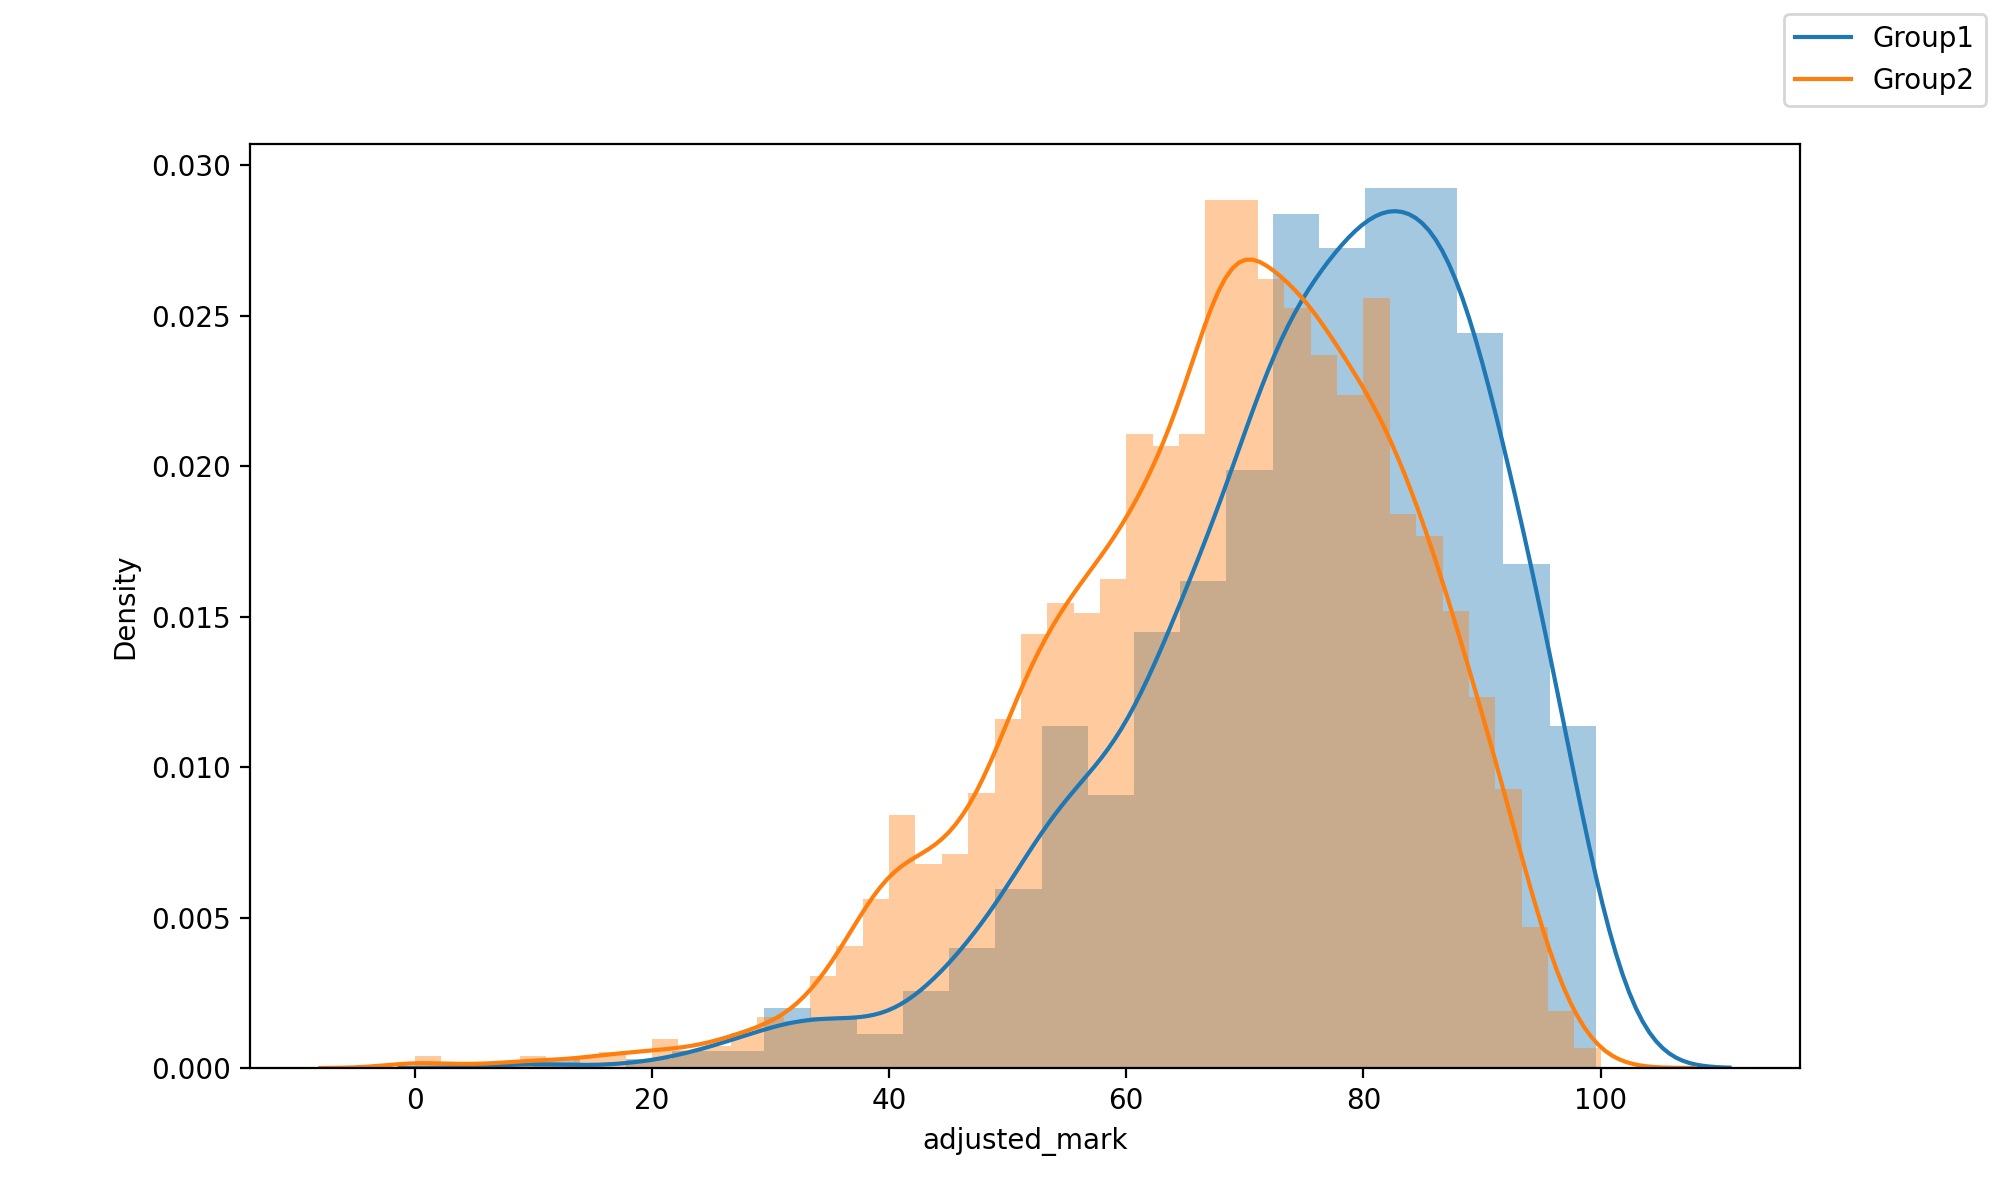

In [83]:
# Kita visualisasi adj_mark untuk setiap kelompok
fig = plt.figure(figsize=(10,6))
sns.distplot(group1.adjusted_mark)
sns.distplot(group2.adjusted_mark)

fig.legend(labels=['Group1','Group2'])
plt.show()

Dapat dilihat dari plot di atas bahwa benar bahwa kelompok 1 (Lebih tua=lebih sukses) mempunyai nilai jauh lebih unggul dibandingkan kelompok 2 (Muda=sulit sukses).

Hal ini ditunjukkan bahwa grafik biru sangat condong ke kanan di mana nilai di sumbu X lebih baik